In [1]:
%matplotlib inline

# Bible NLP

In this notebook, we will apply some natural language processing techniques to some chocen texts from the Gospels.

The goal is to verify the behavior of these techniques with these particular texts, in particular if they can capture information without changing the meaning of the text.

The verses are taken from the tables of Synoptic Gospel Parallels from [gospelparallels.com](https://www.gospelparallels.com/index.html).

We will consider every table as a single category, and we will use the verses as documents.

The verses are taken using the API from [bible-api.com](https://bible-api.com).

In [2]:
import time
import pandas as pd
import requests

# Given a reference return the text of the verse
def get_verse_text(verse: str):
    query = verse.replace(' ', '+')
    url = f'https://bible-api.com/{query}'
    response = requests.get(url)

    if response.status_code == 200:
        json = response.json()
        return json['reference'], json['text'], response.status_code
    else:
        return verse, None, response.status_code

def load_data(verses):
    verses_text = {}
    i = 0
    for verse in verses:
        wait = 4
        while True:
            ref, text, code = get_verse_text(verse)

            if code == 200:
                i += 1
                verses_text[ref] = text
                print(f'{i}/{len(verses)}: {ref}')
                break
            elif code == 429:
                print(f"Error {code}, next attempt in", wait, "seconds")
                time.sleep(wait)
                wait *= 2
            else:
                print(f"Error {code} for {ref}")
                break

    return pd.DataFrame({'verse': verses_text.keys(), 'text': verses_text.values()})

In [3]:
import os
import pandas as pd
import regex as re
from collections import defaultdict

def load_dataset(path_to_save: str, path_to_dataset: str):
    verses = defaultdict(lambda: ['', set()])
    for filename in os.listdir(path_to_dataset):
        f = os.path.join(path_to_dataset, filename)
        df = pd.read_csv(f, sep=',', encoding='utf-8', index_col=0)
        for index, row in df.iterrows():
            for col in df.columns:
                if pd.notnull(row[col]):
                    vs = row[col].split('\n ')
                    for verse in vs:
                        verse = re.sub(r'[a-z]+', '', verse)
                        verses[f"{col} {verse}"][1].add(filename.replace('.csv', ''))
                        verses[f"{col} {verse}"][0] = index

    df = load_data(verses)
    df['category'] = df['verse'].apply(lambda x: ';'.join(verses[x][1]))
    df['pericope'] = df['verse'].apply(lambda x: verses[x][0])
    df.to_csv(path_to_save, sep=',', encoding='utf-8')

In [4]:
import os
import pandas as pd

if not os.path.exists('data/verses.csv'):
    load_dataset('data/verses.csv', 'data/verses')

verses_df = pd.read_csv('data/verses.csv', sep=',', encoding='utf-8')
verses_df['category'] = verses_df['category'].apply(lambda x: list(x.split(';')))

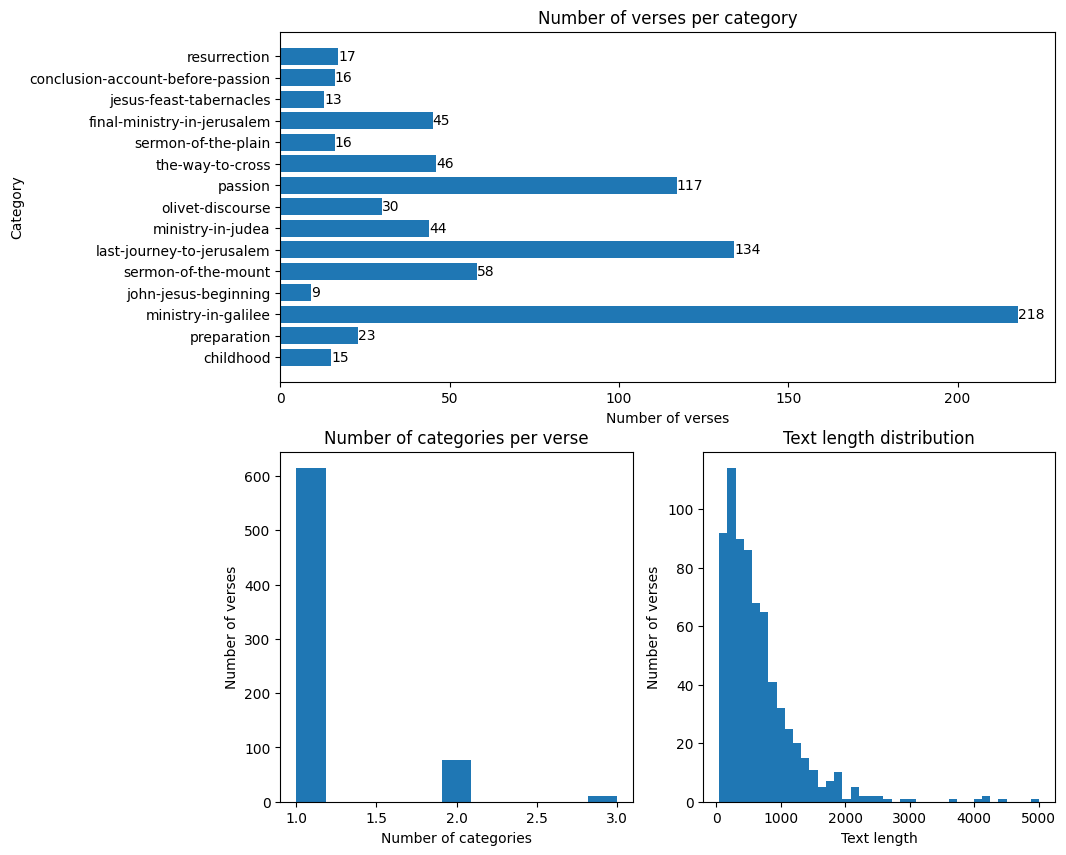

In [5]:
from collections import defaultdict
import matplotlib.pyplot as plt

category_verses = defaultdict(int)
for categories in verses_df['category']:
    for category in categories:
        category_verses[category] += 1

categories = list(category_verses.keys())

verses_category = {}
texts_length = {}
for _, row in verses_df.iterrows():
    verses_category[row['verse']] = len(row['category'])
    texts_length[row['verse']] = len(row['text'])

_, axd = plt.subplot_mosaic([['upper', 'upper'], ['lower left', 'lower right']], figsize=(10, 10))

bars = axd['upper'].barh(categories, list(category_verses.values()))
axd['upper'].bar_label(bars)
axd['upper'].set(xlabel='Number of verses', ylabel='Category', title='Number of verses per category')

axd['lower left'].hist(list(verses_category.values()), bins='auto')
axd['lower left'].set(xlabel='Number of categories', ylabel='Number of verses', title='Number of categories per verse')

axd['lower right'].hist(list(texts_length.values()), bins='auto')
axd['lower right'].set(xlabel='Text length', ylabel='Number of verses', title='Text length distribution')
plt.show()

The distribution of the categories in the dataset is not very balanced and we have a conspicuous number of verses that belong to 2 or more categories.

With regards to the distribution of the lenght of the texts we can see that the majority of the verses are short (below 1000 characters), but there are also some outliers that are very long (above 5000 characters).

## Classification

In this task we will try to classificate the texts using entropy and information gain for scoring the words, and then we will compare four different classifiers: Decision Tree, Random Forest, Multinomial Naive Bayes and One-vs-Rest Logistic Regression (it creates a binary classifier for each category). The last one is used for trying if a one-vs-rest approach can improve the results respect to inherently multiclass classifiers.

So, because we have some verses that belong to more than one category and we want to use a classifier that can only assign one category to each sample, we will use the following strategy: if a sample belongs to more than one category, the sample will be deleted.

This is necessary because entropy and information gain (as we defined them) doesn't have a way to deal with multilabel data.

We will only consider the categories that have at least 25 samples. This threshold is chosen because it consent us to have a better balanced dataset and to have a good number of samples for maintaining stable the results of the classifiers among different runs.

522

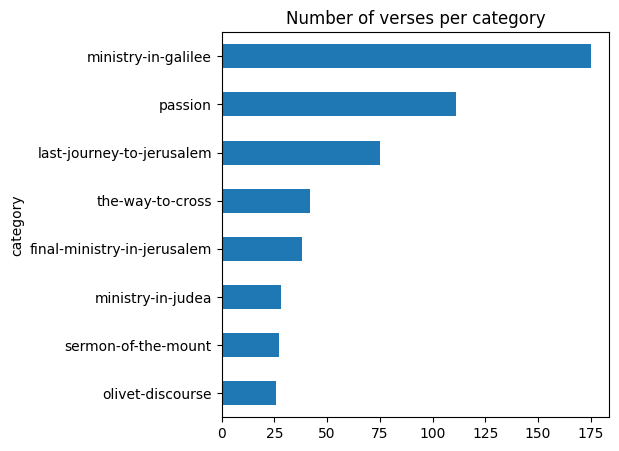

In [6]:
import pandas as pd

verses_df = pd.read_csv('data/verses.csv', sep=',', encoding='utf-8')

verses_df['category'] = verses_df['category'].apply(lambda x: x.split(';'))
verses_df = verses_df[verses_df['category'].apply(lambda x: len(x) == 1)]
verses_df['category'] = verses_df['category'].apply(lambda x: x[0])

allowed_categories = verses_df['category'].value_counts()
allowed_categories = allowed_categories[allowed_categories >= 25]
allowed_categories = allowed_categories.sort_values(ascending=True)
allowed_categories.plot.barh(figsize=(5, 5), title='Number of verses per category')

verses_df = verses_df[verses_df['category'].isin(allowed_categories.index.tolist())]
verses_df = verses_df[['verse', 'text', 'category']].reset_index(drop=True)

display(len(verses_df))

In [7]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from collections import defaultdict
import numpy as np

def preprocess(text, n):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha() and token not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    ngrams_set = set()
    for i in range(1, n+1):
        processed_text = ngrams(tokens, i)
        ngrams_set.update([' '.join(gram) for gram in processed_text])
    return ngrams_set

def build_token_dictionary(tokens: pd.Series):
    tokens_dict = defaultdict(set)
    for idx, record in enumerate(tokens):
        for token in record:
            tokens_dict[token].add(idx)
    return tokens_dict
    
def entropy(df: pd.DataFrame):
    categories = df['category'].unique()
    entropy = 0
    for label in categories:
        p = len(df[df['category'] == label]) / len(df)
        entropy -= p * np.log(p)
    return entropy
    
def information_gain(df: pd.DataFrame, H, token: str):
    token_df = df[df['tokens'].apply(lambda x: token in x)]
    token_count = len(token_df)
    token_entropy = entropy(token_df)
    return H - token_count / len(df) * token_entropy

def dataset_preprocessing(verses_df: pd.DataFrame):
    verses_df['tokens'] = verses_df['text'].apply(preprocess, n=3)
    tokens_dict = build_token_dictionary(verses_df['tokens'])
    df_tokens = pd.DataFrame(zip(tokens_dict.keys(), tokens_dict.values()), columns=['token', 'verses'])
    count = []
    for t in df_tokens['verses']:
        count.append(len(t))
    df_tokens['count'] = count
    df_tokens = df_tokens[df_tokens['count'] > 1]

    H = entropy(verses_df)
    df_tokens['information_gain'] = df_tokens['token'].apply(lambda x: information_gain(verses_df, H, x))
    df_tokens.sort_values(by='information_gain', ascending=False, inplace=True)
    return df_tokens

For reducing the effect of unbalanced classes in dataset, we will use a Stratified 10-Folds cross-validator for training and testing the classifiers.

For comparing the classifiers we will use the mean accuracy over the 10 folds.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

def to_numeric(df: pd.DataFrame, best_features: pd.DataFrame, threshold):
    index = {}
    for idx, token in enumerate(best_features['token']):
        index[token] = idx
    data = np.zeros((len(df), threshold))
    target = np.empty(len(df), dtype=object)
    
    for idx, record in df.iterrows():
        for token in record['new_text']:
            data[idx, index[token]] = 1
        
        target[idx] = record['category']
            
    return data, target

def classification(clf, df: pd.DataFrame, verses_df: pd.Series, threshold, class_order: list):
    df_tokens = df[:threshold]

    new_texts = []
    for tokens in verses_df['tokens']:
        intesect = set(tokens).intersection(set(df_tokens['token'].values))
        new_texts.append(intesect)
    verses_df['new_text'] = new_texts
    numeric_df, target = to_numeric(verses_df, df_tokens, threshold)

    scores = cross_val_score(clf, numeric_df, target, cv=StratifiedKFold(n_splits=10), n_jobs=-1)
    predictions = cross_val_predict(clf, numeric_df, target, cv=StratifiedKFold(n_splits=10), n_jobs=-1)
    return scores.mean(), confusion_matrix(target, predictions, labels=class_order)

naive_bayes = MultinomialNB()
logistic_regression = LogisticRegression(multi_class='ovr')
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()

df_tokens = dataset_preprocessing(verses_df)
x_axis = range(100, 450, 50)
class_order = allowed_categories.index.tolist()

scores = {}
for threshold in x_axis:
    a1, c1 = classification(logistic_regression, df_tokens, verses_df, threshold, class_order)
    a2, c2 = classification(decision_tree, df_tokens, verses_df, threshold, class_order)
    a3, c3 = classification(random_forest, df_tokens, verses_df, threshold, class_order)
    a4, c4 = classification(naive_bayes, df_tokens, verses_df, threshold, class_order)
    scores[threshold] = {
        'accuracy' : {
            'logistic_regression': a1, 
            'decision_tree': a2, 
            'random_forest': a3,
            'naive_bayes': a4
            }, 
        'confusion_matrix': {
            'logistic_regression': pd.DataFrame(c1, index=class_order, columns=class_order),
            'decision_tree': pd.DataFrame(c2, index=class_order, columns=class_order),
            'random_forest': pd.DataFrame(c3, index=class_order, columns=class_order),
            'naive_bayes': pd.DataFrame(c4, index=class_order, columns=class_order)
        }
    }

As metrics for evaluating the classifiers we will use the average accuracy among the folds and the confusion matrixes.

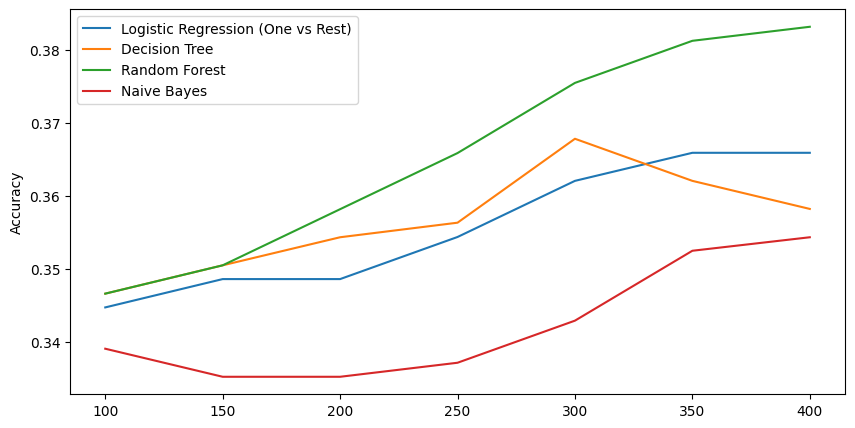

In [9]:
import matplotlib.pyplot as plt
labels = ['Logistic Regression (One vs Rest)', 'Decision Tree', 'Random Forest', 'Naive Bayes']

plt.figure(figsize=(10, 5))
plt.plot(x_axis, [list(x['accuracy'].values()) for x in scores.values()], label=labels)
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The results are the following:

- the best classifier (for average accuracy) is the Random Forest. The worst is the Naive Bayes. There isn't a big difference between the Logistic Regression and the Decision Tree.

- the maximum accuracy is around 35%-40%, similar to the percentage of the most frequent category in the dataset in all cases, so this suggests that the classifiers tend to predict the most frequent category.

Let's analyze the predictions made by the three models at their maximum accuracy features using the confusion matrix.

In [10]:
lr = zip(x_axis, [x['accuracy']['logistic_regression'] for x in scores.values()])
dt = zip(x_axis, [x['accuracy']['decision_tree'] for x in scores.values()])
rf = zip(x_axis, [x['accuracy']['random_forest'] for x in scores.values()])
nb = zip(x_axis, [x['accuracy']['naive_bayes'] for x in scores.values()])

max_lr_idx, max_lr = max(lr, key=lambda x: x[1])
max_dt_idx, max_dt = max(dt, key=lambda x: x[1])
max_rf_idx, max_rf = max(rf, key=lambda x: x[1])
max_nb_idx, max_nb = max(nb, key=lambda x: x[1])

print(f"Confusion matrix of Random Forest with {max_rf_idx} features")
display(scores[max_rf_idx]['confusion_matrix']['random_forest'])
print(f"Accuracy: {max_rf:.4f}\n")

print(f"Confusion matrix of Decision Tree with {max_dt_idx} features")
display(scores[max_dt_idx]['confusion_matrix']['decision_tree'])
print(f"Accuracy: {max_dt:.4f}\n")

print(f"Confusion matrix of One-vs-Rest Logistic Regression with {max_lr_idx} features")
display(scores[max_lr_idx]['confusion_matrix']['logistic_regression'])
print(f"Accuracy: {max_lr:.4f}\n")

print(f"Confusion matrix of Naive Bayes with {max_nb_idx} features")
display(scores[max_nb_idx]['confusion_matrix']['naive_bayes'])
print(f"Accuracy: {max_nb:.4f}\n")

Confusion matrix of Random Forest with 400 features


,olivet-discourse,sermon-of-the-mount,ministry-in-judea,final-ministry-in-jerusalem,the-way-to-cross,last-journey-to-jerusalem,passion,ministry-in-galilee
olivet-discourse,0,0,0,0,0,0,0,26
sermon-of-the-mount,0,0,0,0,0,0,0,27
ministry-in-judea,0,0,12,0,0,0,0,16
final-ministry-in-jerusalem,0,0,0,13,0,0,0,25
the-way-to-cross,0,0,0,0,0,0,0,42
last-journey-to-jerusalem,0,0,0,0,0,0,0,75
passion,0,0,0,0,0,0,0,111
ministry-in-galilee,0,0,0,0,0,0,0,175


Accuracy: 0.3832

Confusion matrix of Decision Tree with 300 features


,olivet-discourse,sermon-of-the-mount,ministry-in-judea,final-ministry-in-jerusalem,the-way-to-cross,last-journey-to-jerusalem,passion,ministry-in-galilee
olivet-discourse,0,0,0,0,0,0,0,26
sermon-of-the-mount,0,0,0,0,0,0,0,27
ministry-in-judea,0,0,5,0,0,0,0,23
final-ministry-in-jerusalem,0,0,0,8,0,0,0,30
the-way-to-cross,0,0,0,0,0,0,0,42
last-journey-to-jerusalem,0,0,0,0,0,0,0,75
passion,0,0,0,0,0,0,0,111
ministry-in-galilee,0,0,0,0,0,0,0,175


Accuracy: 0.3679

Confusion matrix of One-vs-Rest Logistic Regression with 350 features


,olivet-discourse,sermon-of-the-mount,ministry-in-judea,final-ministry-in-jerusalem,the-way-to-cross,last-journey-to-jerusalem,passion,ministry-in-galilee
olivet-discourse,0,0,0,0,0,0,0,26
sermon-of-the-mount,0,0,0,0,0,0,0,27
ministry-in-judea,0,0,6,0,0,0,0,22
final-ministry-in-jerusalem,0,0,0,10,0,0,0,28
the-way-to-cross,0,0,0,0,0,0,0,42
last-journey-to-jerusalem,0,0,0,0,0,0,0,75
passion,0,0,0,0,0,0,0,111
ministry-in-galilee,0,0,0,0,0,0,0,175


Accuracy: 0.3659

Confusion matrix of Naive Bayes with 400 features


,olivet-discourse,sermon-of-the-mount,ministry-in-judea,final-ministry-in-jerusalem,the-way-to-cross,last-journey-to-jerusalem,passion,ministry-in-galilee
olivet-discourse,0,0,0,0,0,0,0,26
sermon-of-the-mount,0,0,0,0,0,0,0,27
ministry-in-judea,0,0,6,0,0,0,6,16
final-ministry-in-jerusalem,0,0,0,5,0,0,16,17
the-way-to-cross,0,0,0,0,0,0,0,42
last-journey-to-jerusalem,0,0,0,0,0,0,0,75
passion,0,0,0,0,0,0,0,111
ministry-in-galilee,0,0,0,0,0,0,1,174


Accuracy: 0.3544



The confusion matrixes show that the all models predicted the "ministry-in-galilee" category for almost all samples, and this is the reason why the accuracy is similar to the percentage of this category in the dataset.

All models predicted correctly a few samples for "final-ministry-in-jerusalem" and "ministry-in-judea". The Random Forest has the best results because it predicted correctly the most samples of these two categories and the rest of the predictions are almost the same as the other models.

Let's try to fix unbalanced classes in dataset using oversampling. We will do this by duplicating the samples of the categories until they reach the number of samples of the most frequent class.

In [11]:
import pandas as pd

def oversampling(df: pd.DataFrame, allowed_categories: pd.Series):
    max_samples = max(allowed_categories)
    oversampled_df = df.copy()
    counter = oversampled_df['category'].value_counts()
    for category in allowed_categories.index:
        oversampled_df = pd.concat([
            oversampled_df, 
            oversampled_df[oversampled_df['category'] == category].sample(max_samples - counter[category], replace=True, random_state=42)
        ], ignore_index=True)

    oversampled_df.reset_index(drop=True, inplace=True)
    return oversampled_df

In [12]:
oversampled_df = oversampling(verses_df, allowed_categories)
df_tokens = dataset_preprocessing(oversampled_df)
x_axis = range(100, 450, 50)
class_order = allowed_categories.index.tolist()

naive_bayes = MultinomialNB()
logistic_regression = LogisticRegression(multi_class='ovr')
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()

scores = {}
for threshold in x_axis:
    a1, c1 = classification(logistic_regression, df_tokens, oversampled_df, threshold, class_order)
    a2, c2 = classification(decision_tree, df_tokens, oversampled_df, threshold, class_order)
    a3, c3 = classification(random_forest, df_tokens, oversampled_df, threshold, class_order)
    a4, c4 = classification(naive_bayes, df_tokens, oversampled_df, threshold, class_order)
    scores[threshold] = {
        'accuracy' : {
            'logistic_regression': a1, 
            'decision_tree': a2, 
            'random_forest': a3,
            'naive_bayes': a4
            }, 
        'confusion_matrix': {
            'logistic_regression': pd.DataFrame(c1, index=class_order, columns=class_order),
            'decision_tree': pd.DataFrame(c2, index=class_order, columns=class_order),
            'random_forest': pd.DataFrame(c3, index=class_order, columns=class_order),
            'naive_bayes': pd.DataFrame(c4, index=class_order, columns=class_order)
        }
    }

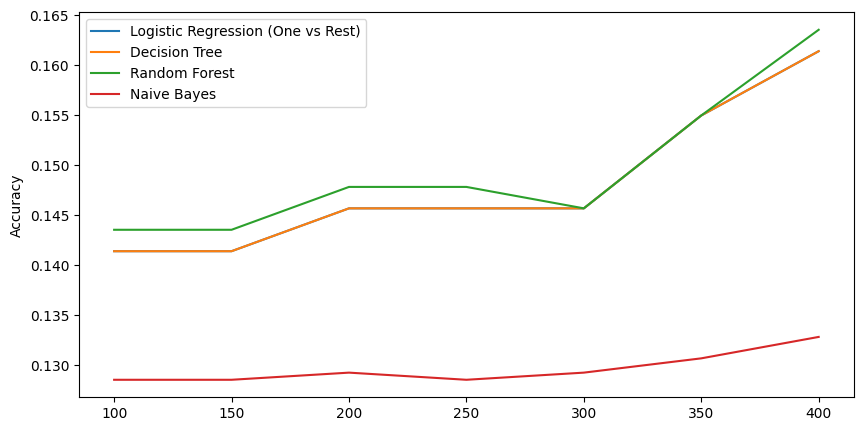

In [13]:
import matplotlib.pyplot as plt
labels = ['Logistic Regression (One vs Rest)', 'Decision Tree', 'Random Forest', 'Naive Bayes']

plt.figure(figsize=(10, 5))
plt.plot(x_axis, [list(x['accuracy'].values()) for x in scores.values()], label=labels)
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
lr = zip(x_axis, [x['accuracy']['logistic_regression'] for x in scores.values()])
dt = zip(x_axis, [x['accuracy']['decision_tree'] for x in scores.values()])
rf = zip(x_axis, [x['accuracy']['random_forest'] for x in scores.values()])
nb = zip(x_axis, [x['accuracy']['naive_bayes'] for x in scores.values()])

max_lr_idx, max_lr = max(lr, key=lambda x: x[1])
max_dt_idx, max_dt = max(dt, key=lambda x: x[1])
max_rf_idx, max_rf = max(rf, key=lambda x: x[1])
max_nb_idx, max_nb = max(nb, key=lambda x: x[1])

print(f"Confusion matrix of Random Forest with {max_rf_idx} features")
display(scores[max_rf_idx]['confusion_matrix']['random_forest'])
print(f"Accuracy: {max_rf:.4f}\n")

print(f"Confusion matrix of Decision Tree with {max_dt_idx} features")
display(scores[max_dt_idx]['confusion_matrix']['decision_tree'])
print(f"Accuracy: {max_dt:.4f}\n")

print(f"Confusion matrix of One-vs-Rest Logistic Regression with {max_lr_idx} features")
display(scores[max_lr_idx]['confusion_matrix']['logistic_regression'])
print(f"Accuracy: {max_lr:.4f}\n")

print(f"Confusion matrix of Naive Bayes with {max_nb_idx} features")
display(scores[max_nb_idx]['confusion_matrix']['naive_bayes'])
print(f"Accuracy: {max_nb:.4f}\n")

Confusion matrix of Random Forest with 400 features


,olivet-discourse,sermon-of-the-mount,ministry-in-judea,final-ministry-in-jerusalem,the-way-to-cross,last-journey-to-jerusalem,passion,ministry-in-galilee
olivet-discourse,69,54,0,0,18,0,17,17
sermon-of-the-mount,71,51,0,0,17,0,18,18
ministry-in-judea,69,54,0,0,18,0,17,17
final-ministry-in-jerusalem,50,33,0,53,11,0,15,13
the-way-to-cross,69,54,0,0,18,0,17,17
last-journey-to-jerusalem,70,50,0,0,17,3,18,17
passion,71,51,0,0,17,0,18,18
ministry-in-galilee,69,54,0,0,18,0,17,17


Accuracy: 0.1636

Confusion matrix of Decision Tree with 400 features


,olivet-discourse,sermon-of-the-mount,ministry-in-judea,final-ministry-in-jerusalem,the-way-to-cross,last-journey-to-jerusalem,passion,ministry-in-galilee
olivet-discourse,0,0,0,0,0,0,90,85
sermon-of-the-mount,0,0,0,0,0,0,85,90
ministry-in-judea,0,0,0,0,0,0,90,85
final-ministry-in-jerusalem,0,0,0,53,0,0,58,64
the-way-to-cross,0,0,0,0,0,0,90,85
last-journey-to-jerusalem,0,0,0,0,0,3,84,88
passion,0,0,0,0,0,0,85,90
ministry-in-galilee,0,0,0,0,0,0,90,85


Accuracy: 0.1614

Confusion matrix of One-vs-Rest Logistic Regression with 400 features


,olivet-discourse,sermon-of-the-mount,ministry-in-judea,final-ministry-in-jerusalem,the-way-to-cross,last-journey-to-jerusalem,passion,ministry-in-galilee
olivet-discourse,0,36,34,0,0,0,54,51
sermon-of-the-mount,0,34,36,0,0,0,51,54
ministry-in-judea,0,36,34,0,0,0,54,51
final-ministry-in-jerusalem,0,22,22,53,0,0,36,42
the-way-to-cross,0,36,34,0,0,0,54,51
last-journey-to-jerusalem,0,34,35,0,0,3,50,53
passion,0,34,36,0,0,0,51,54
ministry-in-galilee,0,36,34,0,0,0,54,51


Accuracy: 0.1614

Confusion matrix of Naive Bayes with 400 features


,olivet-discourse,sermon-of-the-mount,ministry-in-judea,final-ministry-in-jerusalem,the-way-to-cross,last-journey-to-jerusalem,passion,ministry-in-galilee
olivet-discourse,0,0,0,90,0,0,0,85
sermon-of-the-mount,0,0,0,85,0,0,0,90
ministry-in-judea,0,0,0,90,0,0,0,85
final-ministry-in-jerusalem,0,0,0,98,0,0,5,72
the-way-to-cross,0,0,0,90,0,0,0,85
last-journey-to-jerusalem,0,0,0,84,0,3,0,88
passion,0,0,0,85,0,0,0,90
ministry-in-galilee,0,0,0,90,0,0,0,85


Accuracy: 0.1329



The oversampling didn't give us better results, in fact the classifiers have a lower accuracy because they stopped to predict the "ministry-in-galilee" category for almost all samples and they started to predict some samples for the other categories, but the number of correct predictions is still very low and some categories are still not predicted at all.


## Clustering

In this section we will try to cluster the texts using K-Means and TD-IDF technique.

The goal is to see if parallel texts are clustered together varying the number of clusters.

In [44]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

def preprocess(text, n):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [token for token in tokens if token.isalpha() and (
        token not in stopwords.words('english'))]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(
        token) for token in filtered_tokens]
    if n <= 1:
        return lemmatized_tokens
    ngram_set = []
    for i in range(1, n + 1):
        processed_text = ngrams(lemmatized_tokens, i)
        ngram_set.extend([' '.join(grams) for grams in processed_text])
    return ngram_set

In [45]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

verses_df = pd.read_csv('data/verses.csv', sep=',', encoding='utf-8')
verses_df = verses_df[['verse', 'pericope', 'text']]
verses_df = pd.concat([verses_df]*15, ignore_index=True)

verses_df['tokens'] = verses_df['text'].apply(preprocess, n=1)
verses_df['tokens'] = verses_df['tokens'].apply(lambda x: ' '.join(x))

vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(verses_df['tokens'])

Now, before applying the clustering algorithm, we will try to find the optimal number of clusters using the elbow method and the silhouette score.

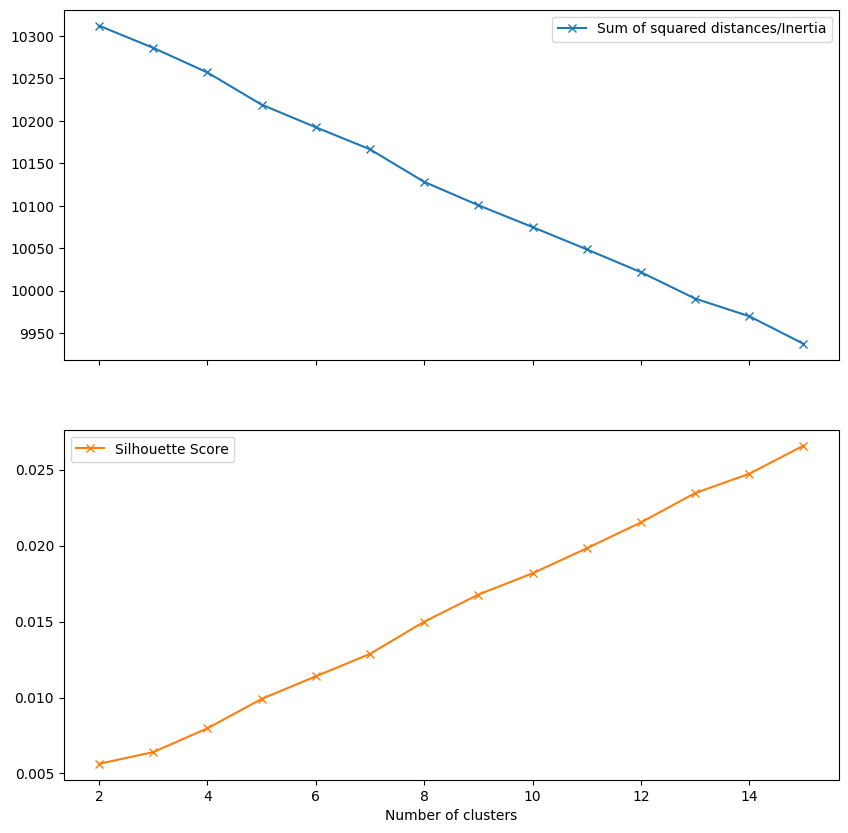

In [46]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt

def silouette_score(X, k):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(X)
    return kmeans.inertia_, silhouette_score(X, kmeans.labels_)

x_axis = range(2, len(categories) + 1)
interitas = []
scores = []
for i in x_axis:
    inertia, score = silouette_score(X, i)
    interitas.append(inertia)
    scores.append(score)

df = pd.DataFrame({'Number of clusters': x_axis ,'Sum of squared distances/Inertia': interitas, 'Silhouette Score': scores})
df.plot(x='Number of clusters', y=['Sum of squared distances/Inertia', 'Silhouette Score'], figsize=(10, 10), subplots=True, marker='x')
plt.show()

From the graph of inertia we cannot find a clear elbow, so we will use only the silhouette score.

The maximum silhouette score is obtained with 13 clusters, but the score is nearly 0, so we can say that we are in presence of overlapping clusters.

In [47]:
import numpy as np
import pandas as pd

def get_top_keywords(X, n_terms, vectorizer):
    df = pd.DataFrame(X.todense()).groupby(verses_df['cluster']).mean()
    terms = vectorizer.get_feature_names_out()

    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]]))

kmeans = KMeans(n_clusters=15, random_state=0, n_init='auto').fit(X)
verses_df['cluster'] = kmeans.labels_
get_top_keywords(X, 20, vectorizer)


Cluster 0
jesus said,also,answered,chief,day,chief priest,god,son,thing,went,saw,came,disciple,saying,one,priest,man,peter,jesus,said

Cluster 1
came,yet,one,jesus answered,jesus said,come,say,word,thing,answered,abraham,became father,disciple,know,god,jew,therefore,jesus,said,father

Cluster 2
jesus,seven,brother,great,herod,came,want,life,adultery,commits adultery,commits,marries,divorce,one,john,among,wife,said,whoever,shall

Cluster 3
beelzebul prince,prince demon,prince,demon cast,multitude,casting demon,healed,demon gone,divided,went,said,name,blind,possessed demon,beelzebul,possessed,mute,cast demon,cast,demon

Cluster 4
ear,lamp,ear hear,given,come,john,measure,jesus,thing see,see thing,prophet,tell,light,said,parable,blessed,eye,thing,hear,see

Cluster 5
authority,came,people,john,preaching good,jesus went,kingdom,went,tree,synagogue,news god,fruit,jesus,preaching,teaching,good news,galilee,every,news,good

Cluster 6
known,like,ready,jesus,man coming,flood,know,like man,sold,

Let's see if the texts with the same pericope are clustered together.

In [61]:
pericopes = verses_df[['pericope', 'verse', 'cluster']].groupby(['pericope', 'cluster']).count()

pericopes.reset_index(inplace=True)

duplicated_pericopes = pericopes[pericopes.duplicated(subset=['pericope'], keep=False)]
print(f"Number of pericopes: {len(verses_df['pericope'].unique())}")
print(f"Number of pericopes which verses aren't all in the same cluster: {len(duplicated_pericopes['pericope'].unique())} ({len(duplicated_pericopes['pericope'].unique()) / len(verses_df['pericope'].unique()) * 100:.2f}%)")

display(duplicated_pericopes['pericope'].unique())

Number of pericopes: 313
Number of pericopes which verses aren't all in the same cluster: 119 (38.02%)


array(['Commissioning the Twelve', 'Concerning Light',
       'Concerning the Law',
       'Conclusion. “Take Heed, Watch!” (According to Mark)',
       'Conditions of Discipleship', 'Departure to Judea',
       'Discourses against the Pharisees and Lawyers',
       'Division in Households', 'Encouragement and Answer to Prayer',
       'Exclusion from the Kingdom, the Straight Gate',
       'Exhortation to Fearless Confession',
       'False Christs and False Prophets', 'Feeding the Five Thousand',
       'First Preaching Tour in Galilee',
       'Healing and Cleansing of the Leper',
       'Healing of the Demoniac in the Synagogue',
       'Healing the Withered Hand', 'Healings at Gennesaret',
       'Herod Thinks Jesus is John, Raised',
       'Interpretation of the Parable of the Sower',
       'Jesus Appears to His Disciples (Thomas being Absent)',
       'Jesus Appears to the Women', 'Jesus Blesses the Children',
       'Jesus Delivered to Pilate', 'Jesus Departs from Capernaurn',

There are some pericopes that have verses in different clusters, but the majority of the pericopes have verses in the same cluster.

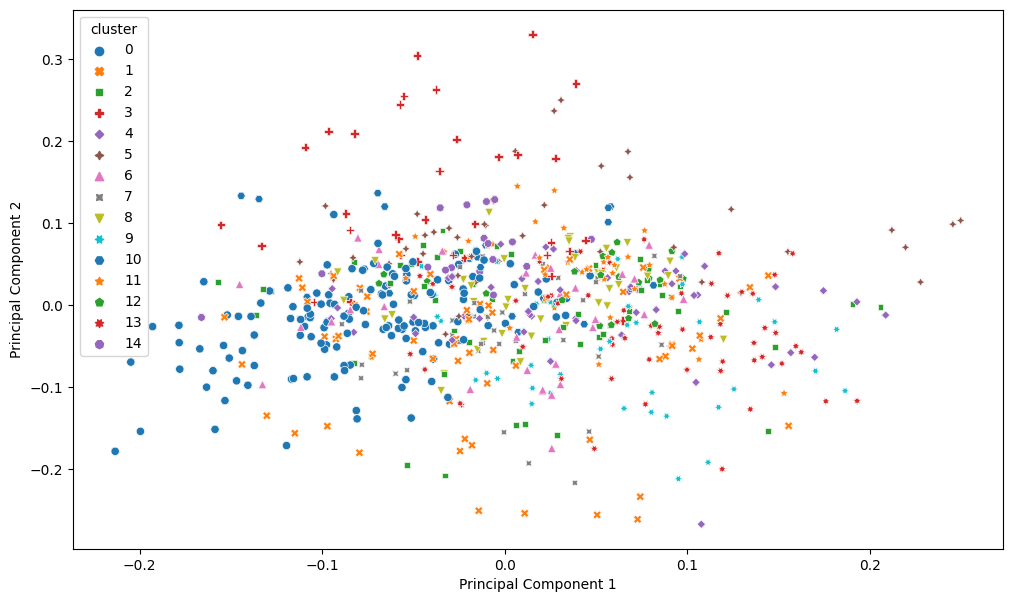

In [49]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X.toarray())

verses_df['x0'] = principal_components[:, 0]
verses_df['x1'] = principal_components[:, 1]

plt.figure(figsize=(12, 7))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
sns.scatterplot(data=verses_df, x='x0', y='x1', hue='cluster', palette='tab10', style='cluster')
plt.show()

The PCA plot shows that the clusters are not well separated, confirming the results of the silhouette score.

The obtained clusters seems quite different from the real categories, in fact reading the feature words of the clusters seems that the clustering algorithm has grouped the texts for macro-arguments, for example the cluster 0 talks about the Passion of Jesus, while the cluster 1 talks about marriage and divorce.

The problem is that there a are a lot of words that are common to all clusters, so the clustering algorithm cannot distinguish well the texts.

## Summarization

In this section we will try to summarize some texts using Sentence Scoring and Sentence Extraction techniques.

- The Sermon on the Mount (Matthew 5-7)

- The Last Supper from the Gospel of John (John 13-17)

- The Parable of the Prodigal Son (Luke 15,11-32)

- The Passion of Jesus from the Gospel of Luke (Luke 22-23)

In [21]:
def summarizing_verses():
    verses = [
        'Matthew 5:1-7:29', # Sermon on the Mount
        'John 13:1-17:26',  # The Last Supper
        'Luke 22:1-23:56',  # The Passion
        'Luke 15:11-32',    # Parable of the Prodigal Son
    ]
    verses_df = load_data(verses)
    verses_df.to_csv('data/summarizing_verses.csv', index=False)

In [22]:
import os
import pandas as pd

if not os.path.exists('data/summarizing_verses.csv'):
    summarizing_verses()
    
verses_df = pd.read_csv('data/summarizing_verses.csv')
verses_df

,verse,text
0,Matthew 5:1-7:29,"Seeing the multitudes, he went up onto the mou..."
1,John 13:1-17:26,"Now before the feast of the Passover, Jesus, k..."
2,Luke 22:1-23:56,"Now the feast of unleavened bread, which is ca..."
3,Luke 15:11-32,"He said,\n“A certain man had two sons.\n\n\nTh..."


In [23]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import defaultdict
import numpy as np
import re

def preprocess(text, lemmatizer, n):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha(
    ) and token not in stopwords.words('english')]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    if n <= 1:
        return tokens

    ngrams_set = []
    for i in range(1, n+1):
        processed_text = ngrams(tokens, i)
        ngrams_set.extend([' '.join(grams) for grams in processed_text])
    return ngrams_set

def gen_summary(sentences, scores, threshold):
    summary = []
    for idx, sentence in enumerate(sentences):
        s = re.sub(r'\s+', ' ', sentence)
        if scores[idx] >= threshold:
            summary.append(s)
    return summary

def threshold(*args):
    return args[1] * np.mean(list(args[0]))

For Sentence Scoring, instead of using frequentistic methods (like TF-IDF), we will use Latent Dirichlet Allocation (LDA) to find the most important topics in the text and use the probability of the tokens in the topics as weight. If a tokens compares in more than one topic, the sum of the probabilities is used.

The score of a sentence is calculated in this way:

1. the sentence is tokenized in words and the tokens are lemmatized

2. for each token if the token is in the list of the most important tokens obtained from LDA, the score of the token is added to the score of the sentence

3. the score of the sentence is divided by the number of relevant tokens found during the previous step (in this way short sentences are not penalized)

In [24]:
from gensim import corpora, models

def text_lda(sentences):
    lemmatizer = WordNetLemmatizer()
    tokens = [preprocess(sentence, lemmatizer, 1) for sentence in sentences]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    lda = models.LdaModel(corpus, id2word=dictionary, num_topics=4)

    scores = defaultdict(lambda: 0)
    for topic, _ in lda.top_topics(corpus, coherence='u_mass', topn=10):
        for score, token in topic:
            scores[token] += score

    return dict(scores)

def score_sentence_lda(sentences, lda_scores, lemmatizer):
    sentence_score = {}
    for idx, sentence in enumerate(sentences):
        score = 0
        relevant_tokens = 0
        for token in word_tokenize(sentence.lower()):
            token = lemmatizer.lemmatize(token)
            if token in lda_scores:
                score += lda_scores[token]
                relevant_tokens += 1
        sentence_score[idx] = score / relevant_tokens if relevant_tokens > 0 else 0
    return sentence_score

In [25]:
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
verses_df['sentences'] = verses_df['text'].apply(sent_tokenize)
verses_df['lda_scores'] = verses_df['sentences'].apply(text_lda)
verses_df['sentence_scores'] = verses_df.apply(lambda x: score_sentence_lda(x['sentences'], x['lda_scores'], lemmatizer), axis=1)

In [26]:
verses_df['alpha'] = [1.8, 1.5, 1.6, 1]
verses_df['summary'] = verses_df.apply(lambda x: gen_summary(x['sentences'], x['sentence_scores'], threshold(x['sentence_scores'].values(), x['alpha'])), axis=1)

for _, row in verses_df.iterrows():
    print(row['verse'])
    print('\n'.join(row['summary']))
    print(f"\nOriginal size: {len(row['sentences'])} sentences, summary size: {len(row['summary'])} sentences")
    print("\n")

Matthew 5:1-7:29
Blessed are those who mourn, for they shall be comforted.
Blessed are the gentle, for they shall inherit the earth.
Blessed are those who hunger and thirst after righteousness, for they shall be filled.
Blessed are the merciful, for they shall obtain mercy.
Blessed are the pure in heart, for they shall see God.
Blessed are the peacemakers, for they shall be called children of God.
Whoever, therefore, shall break one of these least commandments, and teach others to do so, shall be called least in the Kingdom of Heaven; but whoever shall do and teach them shall be called great in the Kingdom of Heaven.
For I tell you that unless your righteousness exceeds that of the scribes and Pharisees, there is no way you will enter into the Kingdom of Heaven.
Most certainly I tell you, you shall by no means get out of there, until you have paid the last penny.
“You have heard that it was said, ‘You shall not commit adultery;’ but I tell you that everyone who gazes at a woman to lust

The model used for Sentence Scoring seems to work well.

The summaries obtained are coherent with the original texts. In particular we observe a tendency to summarize the texts using long sentences, which is good for this kind of texts, but it is bad for the size of the summaries.

Very appreciated is the fact that the start of dialogs are almost always included in the summaries, which is very important for understanding the context (this was a problem with the summaries obtained using frequentistic methods like TF-IDF).

## Conclusions

The result obtained for the classification and clustering tasks are not very good.

I think that the main problem is in the dataset in particular in:

- the unbalancing of the categories (we tried to fix this problem using oversampling, but the results are worse),

- the nature of the categories: they are made according to combined chronological (two verses are in the same category because they are near in the original text) and thematic criteria and it seems that the tecniques used are not able to capture this type of information,

    - probably a way to improve the results could be adding the information about the order of the verses in the original text (e.g. something like positional encoding).

For the summarising task, the results are promising, so I think that the model used is good for this kind of texts, but the summaries obtained are quite long, so the model should be improved, for example by trying different methods for scoring the sentences and calculating the summaries.